In [6]:
from nga.utils import (
    load_config, plane_eval_ray_bundle, save_as_image, read_depth_map, compute_errors,
    load_metadata
)
from nerfstudio.utils.eval_utils import eval_load_checkpoint
from nerfstudio.cameras.rays import RayBundle
from nerfstudio.utils import colormaps
from nerfstudio.utils.io import load_from_json

from PIL import Image
from pathlib import Path
import yaml
import torch
import json
import numpy as np
import matplotlib.pyplot as plt

In [56]:
# config_path = "outputs/pattern_plane1_100_10_10/tensorf/2023-09-22_013551/config.yml"
# config_path = "outputs/pattern_plane1_100_10_10/tensorf/2023-09-21_220947/config.yml"
# config_path = "outputs/pattern_plane1_100_10_10/nerfacto/2023-09-22_020606/config.yml"
# config_path = "outputs/pattern_plane1_100_10_10/kplanes/{timestamp}/config.yml"
# config_path = "outputs/pattern_plane1_100_10_10/instant-ngp-bounded/2023-09-22_012617/config.yml"
# config_path = "outputs/pattern_plane1_100_10_10/tensorf/2023-09-22_150006/config.yml"
# config_path = "outputs/pattern_plane1_100_10_10/instant-ngp/2023-09-22_155638/config.yml"
# config_path = "outputs/pattern_plane1_10-90deg/instant-ngp/2023-09-22_190351/config.yml"
# config_path = "outputs/pattern_plane1_10-90deg/instant-ngp-bounded/2023-09-22_194212/config.yml"
# config_path = "outputs/pattern_plane1_10-90deg/kplanes/2023-09-22_191526/config.yml"
# config_path = "outputs/pattern_plane1_10-90deg/nerfacto/2023-09-22_195124/config.yml"
config_path = "outputs/pattern_plane1_10-90deg/tensorf/2023-09-22_183602/config.yml"


plane_dimensions=(1.0,1.0)

config = load_config(config_path)
config.load_dir = config.get_checkpoint_dir()

meta, data_dir = load_metadata(config)


In [57]:

# setup pipeline (which includes the DataManager)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipeline = config.pipeline.setup(device=device, test_mode="val")
pipeline.eval()


checkpoint_path, step = eval_load_checkpoint(config, pipeline)
results_path = config.get_base_dir() / "results.json"
render_output_path = config.get_base_dir() / "renders"
render_output_path.mkdir(parents=True, exist_ok=True)

[11:51:37] Auto image downscale factor of 1                                                 ]8;id=529233;file:///home/ccl/Code/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=820540;file:///home/ccl/Code/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#349\349]8;;\

            Dataset is overriding train_indices to [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, ]8;id=747523;file:///home/ccl/Code/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=150239;file:///home/ccl/Code/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#200\200]8;;\
           20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,                              
           40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,                              
           60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79,                              
           80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99,                              
           100, 101, 102, 103, 104, 105, 106, 107, 108, 109]                                                            

            Dataset is overriding val_indices to [110, 111, 112, 113, 114, 115, 116, 117,   ]8;id=934510;file:///home/ccl/Code/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=252778;file:///home/ccl/Code/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#200\200]8;;\
           118, 119]                                                                                                    

Setting up training dataset...

Caching all 100 images.

Output()

Setting up evaluation dataset...

Caching all 10 images.

Output()

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/pattern_plane1_10-90deg/tensorf/2023-09-22_183602/nerfstudio_models/step-000029999.ckpt

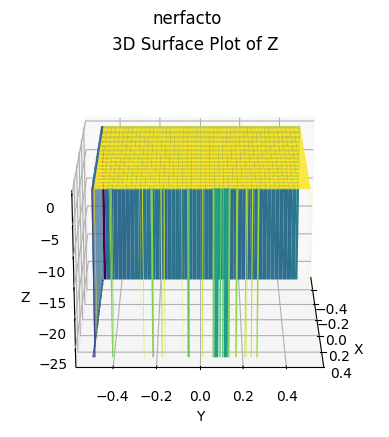

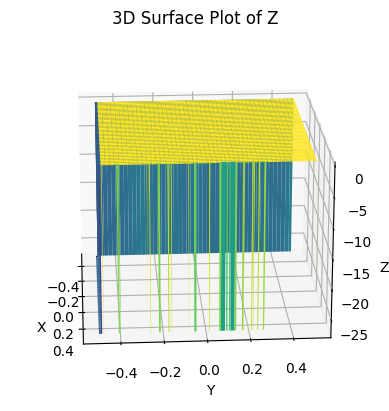

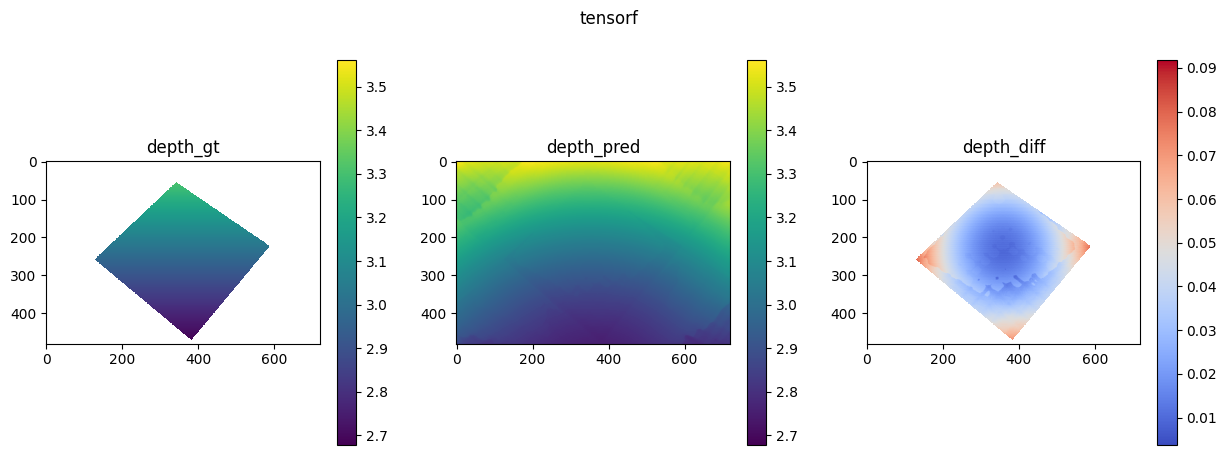

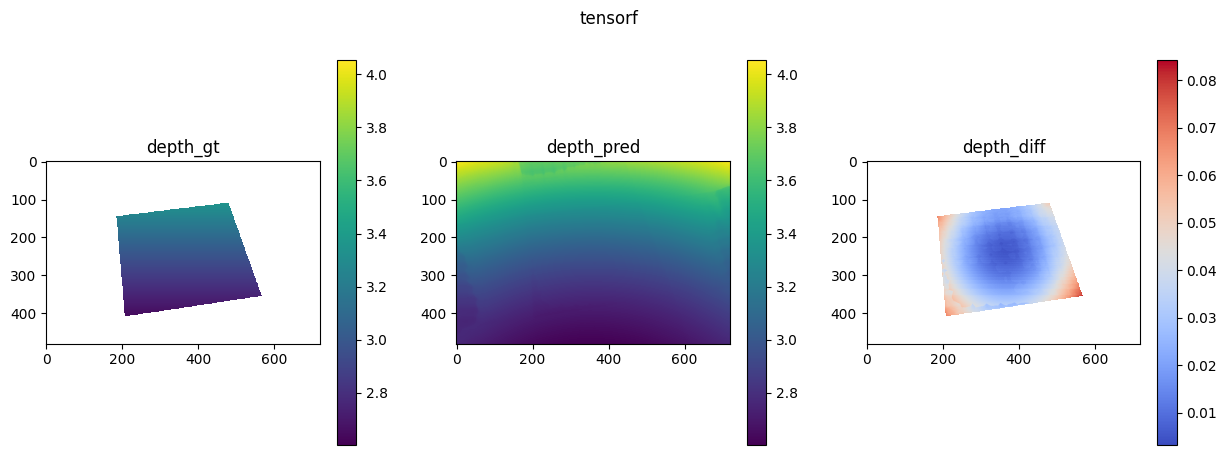

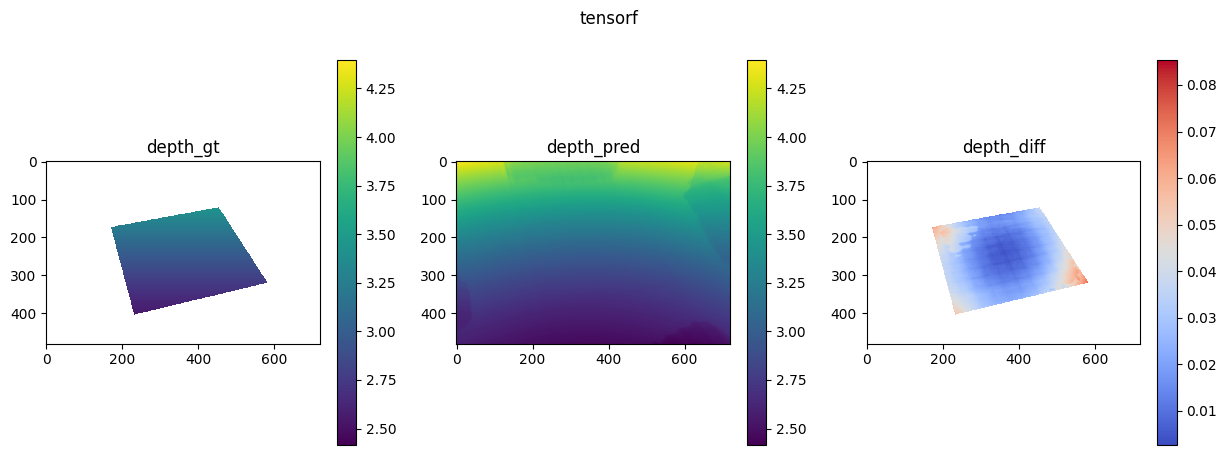

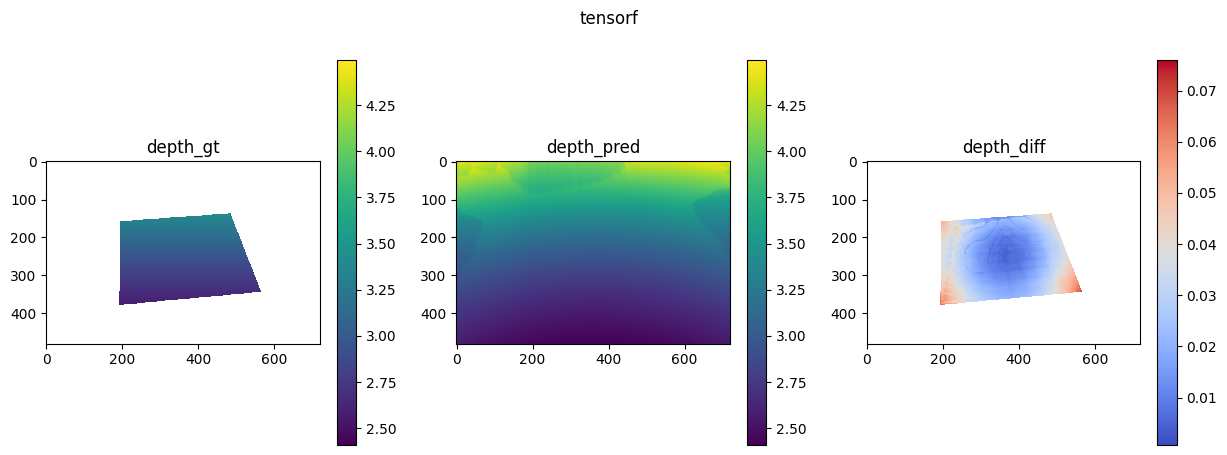

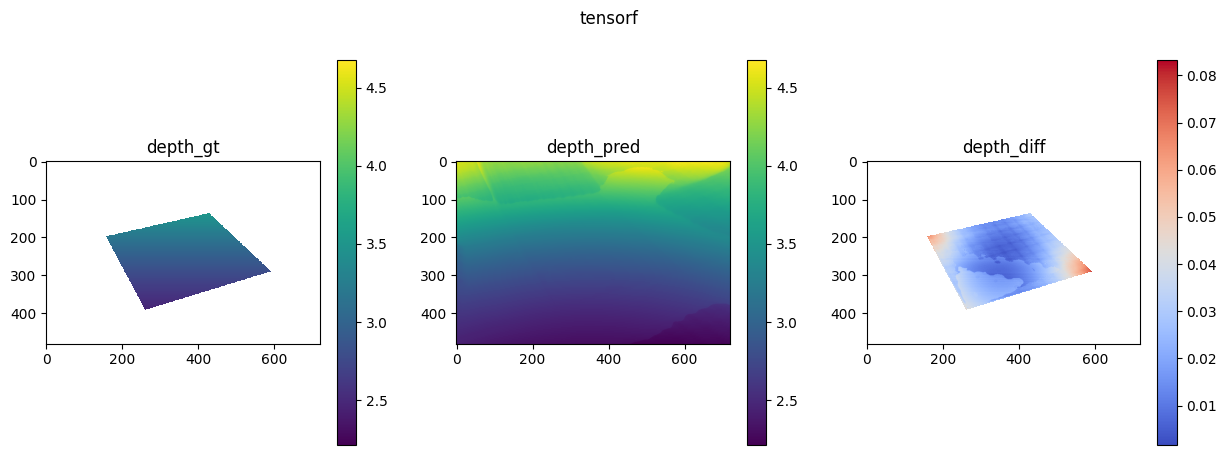

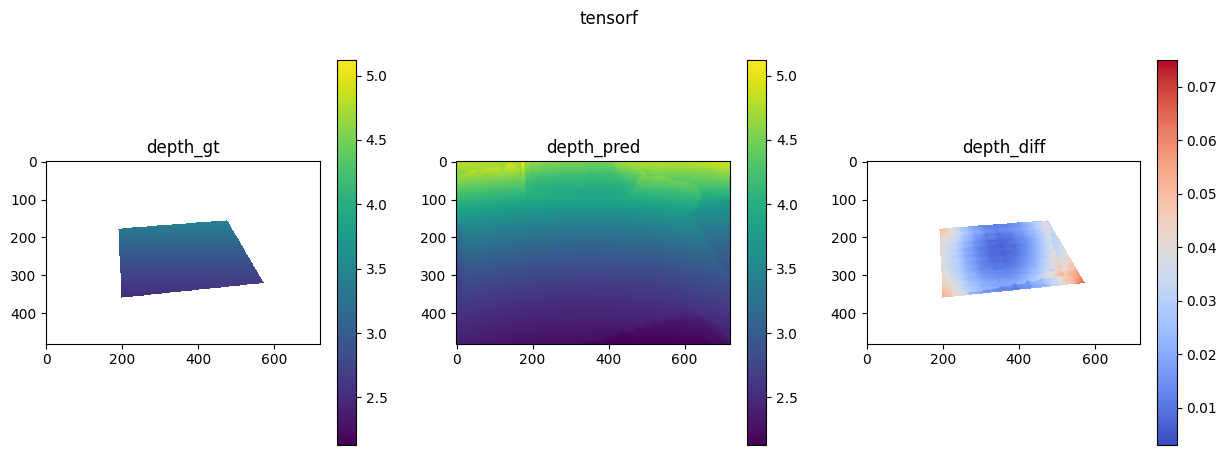

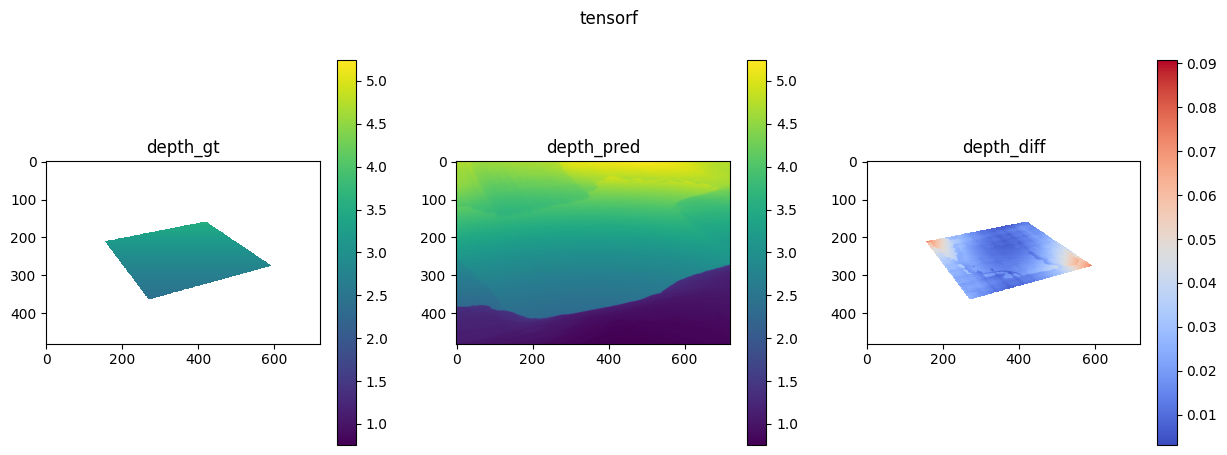

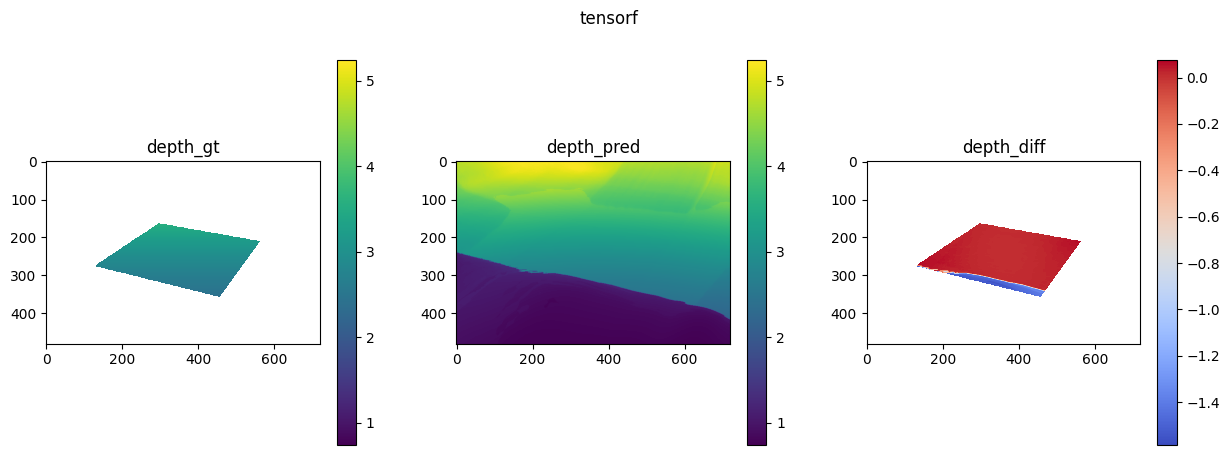

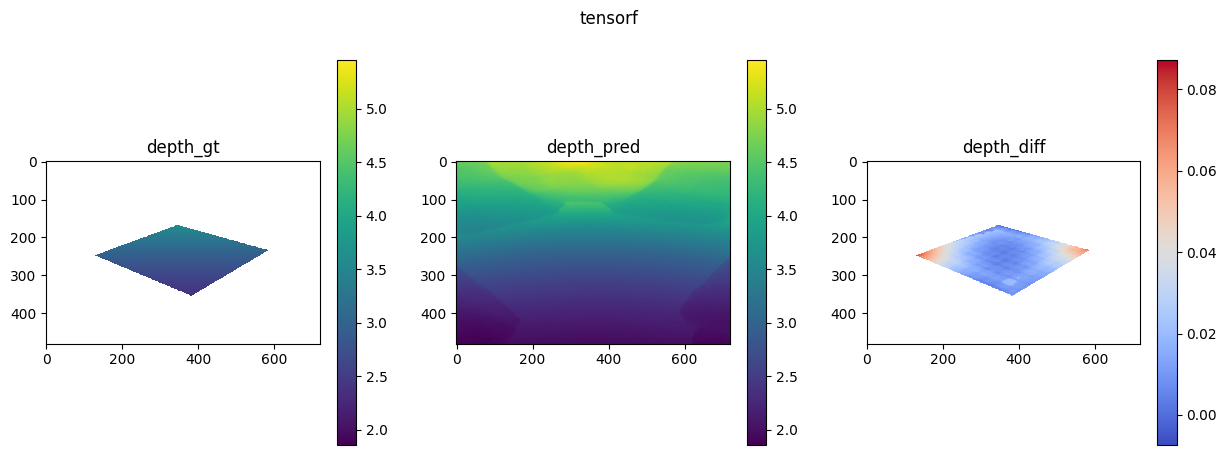

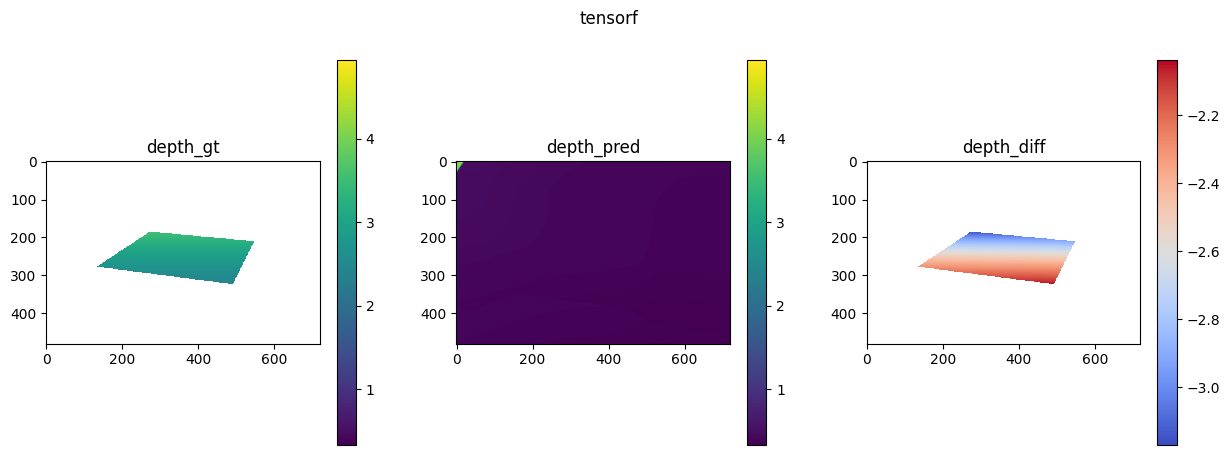

In [58]:
%matplotlib inline

depth_filenames = pipeline.datamanager.eval_dataset.metadata["depth_filenames"]

# load data for coverting between original and normalized coodinate space
dataparser_transforms_path = config.get_base_dir() / "dataparser_transforms.json"
dataparser_transforms_data = json.load(open(dataparser_transforms_path))
dataparser_scale = dataparser_transforms_data["scale"]
transform = torch.tensor(dataparser_transforms_data["transform"])


def save_depth_vis(file_path, config, depth_gt, depth_pred, depth_diff, mask):
    # Convert torch tensors to numpy arrays and apply mask
    depth_gt_np = depth_gt.to("cpu").numpy()
    depth_pred_np = depth_pred.to("cpu").numpy()
    depth_diff_np = depth_diff.to("cpu").numpy()

    mask_np = mask.to("cpu").numpy()

    depth_gt_masked = np.ma.masked_where(mask_np == 0, depth_gt_np)
    depth_pred_masked = depth_pred_np
    depth_diff_masked = np.ma.masked_where(mask_np == 0, depth_diff_np)
    # Find min and max depth values for a unified color scale
    vmin = min(np.min(depth_gt_masked), np.min(depth_pred_masked))
    vmax = max(np.max(depth_gt_masked), np.max(depth_pred_masked))

    # Create the subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(config.method_name)

    # Plot the heatmaps
    cax1 = axs[0].imshow(depth_gt_masked, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[0].set_title('depth_gt')
    fig.colorbar(cax1, ax=axs[0])

    cax2 = axs[1].imshow(depth_pred_masked, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[1].set_title('depth_pred')
    fig.colorbar(cax2, ax=axs[1])

    cax3 = axs[2].imshow(depth_diff_masked, cmap='coolwarm')
    axs[2].set_title('depth_diff')
    fig.colorbar(cax3, ax=axs[2])

    plt.savefig(file_path)


num_images = len(pipeline.datamanager.fixed_indices_eval_dataloader)
depth_silog = np.zeros(num_images, np.float32)
depth_log10 = np.zeros(num_images, np.float32)
depth_rms = np.zeros(num_images, np.float32)
depth_log_rms = np.zeros(num_images, np.float32)
depth_abs_rel = np.zeros(num_images, np.float32)
depth_sq_rel = np.zeros(num_images, np.float32)
depth_d1 = np.zeros(num_images, np.float32)
depth_d2 = np.zeros(num_images, np.float32)
depth_d3 = np.zeros(num_images, np.float32)

for camera_ray_bundle, batch in pipeline.datamanager.fixed_indices_eval_dataloader:
    image_idx = batch["image_idx"]
    depth_filepath = depth_filenames[image_idx]
    depth_gt = read_depth_map(str(depth_filepath), device)
    mask = depth_gt <= 1000
    depth_gt[depth_gt > 1000] = torch.min(depth_gt[mask])
    outputs = pipeline.model.get_outputs_for_camera_ray_bundle(camera_ray_bundle)

    rgb_pred = outputs["rgb"].cpu()
    rgb_pred = torch.concat([rgb_pred, torch.ones((rgb_pred.shape[0], rgb_pred.shape[1], 1))], dim=-1)
    rgb_gt = batch["image"].cpu()
    
    rgb_compare = torch.concat([rgb_gt, rgb_pred], dim=1)
    acc = outputs["accumulation"]
    acc_vis = colormaps.apply_colormap(acc)

    depth_pred = outputs["depth"] / dataparser_scale

    depth_pred_vis = colormaps.apply_depth_colormap(
        depth_pred,
        accumulation=outputs["accumulation"],
    )
    depth_gt_vis = colormaps.apply_depth_colormap(
        depth_gt,
    )
    depth_gt_vis = torch.concat([depth_gt_vis, mask], dim=-1)
    depth_diff = depth_pred - depth_gt
    depth_diff[depth_gt > 1000] = torch.min(depth_diff[mask])
    depth_diff_vis = colormaps.apply_depth_colormap(
        depth_diff,
    )
    depth_diff_vis = torch.concat([depth_diff_vis, mask], dim=-1)

    save_as_image(rgb_pred, render_output_path / f"rgb_pred_{image_idx:04d}.png")
    save_as_image(rgb_gt, render_output_path / f"rgb_gt_{image_idx:04d}.png")
    save_as_image(rgb_compare, render_output_path / f"rgb_compare_{image_idx:04d}.png")
    save_as_image(acc_vis, render_output_path / f"acc_{image_idx:04d}.png")
    save_as_image(depth_pred_vis, render_output_path / f"depth_pred_{image_idx:04d}.png")
    save_as_image(depth_gt_vis, render_output_path / f"depth_gt_{image_idx:04d}.png")
    save_as_image(depth_diff_vis, render_output_path / f"depth_diff_{image_idx:04d}.png")
    save_depth_vis(render_output_path / f"depth_plot_{image_idx:04d}.png", config, depth_gt, depth_pred, depth_diff, mask)

    depth_silog[image_idx], depth_log10[image_idx], depth_abs_rel[image_idx], depth_sq_rel[image_idx], depth_rms[image_idx], depth_log_rms[image_idx], depth_d1[image_idx], depth_d2[image_idx], depth_d3[image_idx] = compute_errors(
            depth_gt[mask].to("cpu").numpy(), depth_pred[mask].to("cpu").numpy())
    
    

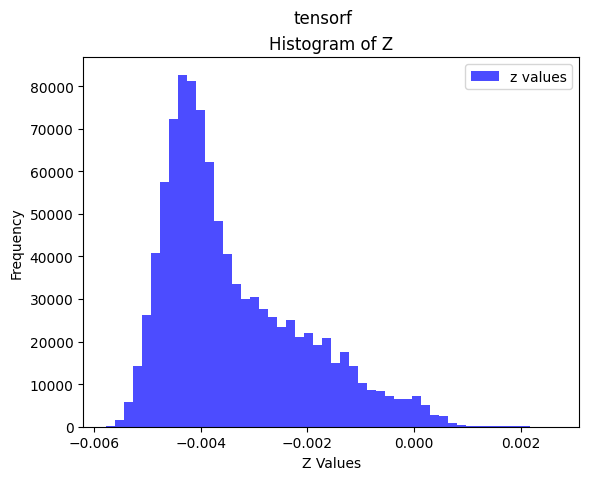

697

In [59]:
%matplotlib inline


sampling_width = 0.5
camera_ray_bundle = plane_eval_ray_bundle(dataparser_transforms_data, sampling_width, dimensions=plane_dimensions).to(device)
outputs = pipeline.model.get_outputs_for_camera_ray_bundle(camera_ray_bundle)

rgb = outputs["rgb"]
depth = outputs["depth"]
mask = depth < 2 * sampling_width
# mask = torch.abs(depth - torch.mean(depth)) < 1 * torch.std(depth)
acc = colormaps.apply_colormap(outputs["accumulation"])
depth_vis = torch.clone(depth)
depth_vis[torch.logical_not(mask)] = torch.min(depth[mask])
depth_vis = colormaps.apply_depth_colormap(
    depth_vis,
    accumulation=outputs["accumulation"],
)
depth_vis = torch.concat([depth_vis, mask], dim=-1)

z = sampling_width - (outputs["depth"] / dataparser_scale)
z_vis = torch.clone(z)
z_vis[torch.logical_not(mask)] = torch.min(z[mask])
z_vis = colormaps.apply_depth_colormap(
    z_vis,
    accumulation=outputs["accumulation"],
)
z_vis = torch.concat([z_vis, mask], dim=-1)

save_as_image(rgb, render_output_path / "rgb.png")
save_as_image(acc, render_output_path / "acc.png")
save_as_image(depth_vis, render_output_path / "depth.png")
save_as_image(z_vis, render_output_path / "z.png")
torch.save(z_vis, render_output_path / "z.pt")

fig = plt.figure()
fig.suptitle(config.method_name)
plt.hist(z.cpu().numpy().flatten(), bins=50, color='blue', alpha=0.7, label='z values')
plt.xlabel('Z Values')
plt.ylabel('Frequency')
plt.title('Histogram of Z')
plt.legend()
plt.savefig(render_output_path / 'z_hist.jpeg')
plt.show()

# Get the output and define the names to save to
benchmark_info = {
    "experiment_name": config.experiment_name,
    "method_name": config.method_name,
    "checkpoint": str(checkpoint_path),
    "results": {
        "max_z": float(torch.max(z)),
        "min_z": float(torch.min(z)),
        "std_z": float(torch.std(z)),
        "mean_z": float(torch.mean(z)),
        "depth_metrics": {
            "silog": float(depth_silog.mean()),
            "log10": float(depth_log10.mean()),
            "abs_rel": float(depth_abs_rel.mean()),
            "sq_rel": float(depth_sq_rel.mean()),
            "rms": float(depth_rms.mean()),
            "log_rms": float(depth_log_rms.mean()),
            "d1": float(depth_d1.mean()),
            "d2": float(depth_d2.mean()),
            "d3": float(depth_d3.mean()),
        }
    },
}
# Save output to output file
results_path.write_text(json.dumps(benchmark_info, indent=2), "utf8")

(1001, 1001)


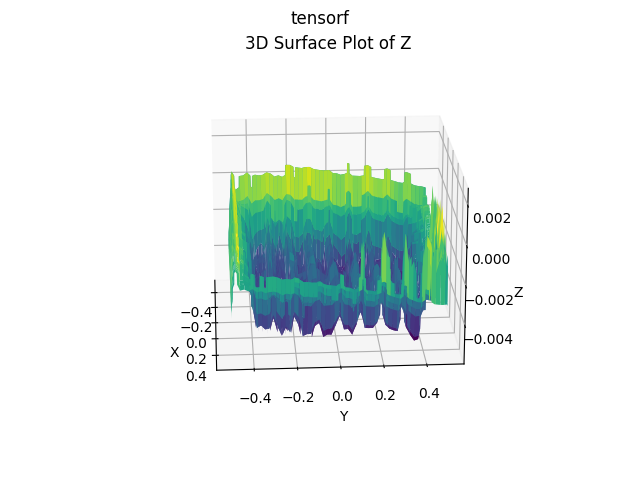

In [60]:
%matplotlib widget
from matplotlib.animation import FuncAnimation

# Convert PyTorch tensor to NumPy array
z_numpy = z.squeeze().cpu().numpy()
print(z_numpy.shape)

# Create x and y coordinates for 1x1 xy-plane centered at origin
x = np.linspace(-0.5, 0.5, 1001)
y = np.linspace(-0.5, 0.5, 1001)
x, y = np.meshgrid(x, y)

# Create the 3D plot
fig = plt.figure()
fig.suptitle(config.method_name)
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(x, y, z_numpy, cmap='viridis')

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Surface Plot of Z')

# Function to update the plot at each frame
def update(frame):
    ax.view_init(elev=20., azim=3.6*frame)
    return surface,

# Create animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 100), blit=False, repeat=False)

# To save the animation
ani.save(render_output_path / '3D_rotation.gif', writer='imagemagick')


# # Show plot
# plt.show()



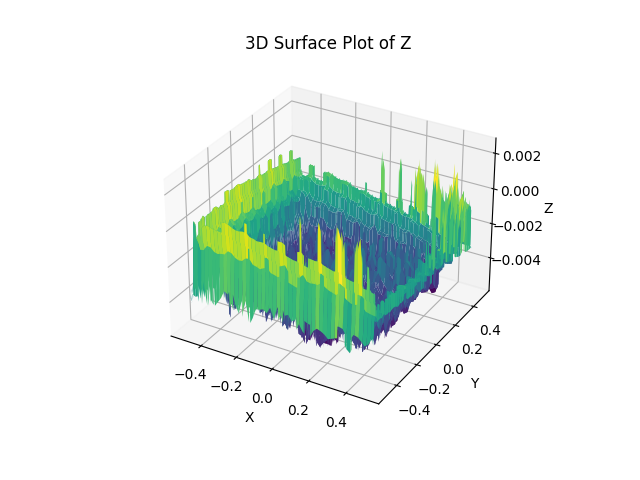

In [61]:
%matplotlib widget

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(x, y, z_numpy, cmap='viridis')

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Surface Plot of Z')


# # Show plot
plt.show()



In [62]:
# %matplotlib inline
# # Number of slices
# num_slices = 10

# # Create the slices
# for i in range(num_slices):
#     # Choose an index for the cross-section along the x-axis
#     slice_index = int((i + 0.5) * (z_numpy.shape[0] / num_slices))  # Replace this with a suitable value within [0, 1000]

#     # Extract the slice
#     z_slice = z_numpy[slice_index, :]

#     # Plotting
#     plt.figure()
#     plt.suptitle(config.method_name)
#     plt.plot(y, z_slice)
#     plt.xlabel('Y')
#     plt.ylabel('Z')
#     plt.title(f'Cross-Section at X-Index {slice_index}')
#     plt.savefig(render_output_path / f'cross_section_{slice_index}.jpeg')
#     # plt.show()


In [63]:
!convert -delay 100 -loop 0  -background black -alpha remove -alpha off {render_output_path}/rgb_compare_*.png {render_output_path}/rgb_compare.gif
!convert -delay 100 -loop 0  -background black -alpha remove -alpha off {render_output_path}/depth_plot_*.png {render_output_path}/depth_plot.gif